# InterWay - Interrail your way!
Course project for Selected Topics in Mathematical Optimization from Robbe Claeys and Jovana Filipovic

# Introduction to the problem

We are planning an Interrail vacation starting in Brussels and ending in Belgrade. To plan our vacaction in the most mathimatically sound way, we've translated it into a graph problem...

However, there are a phew constraints:

1. Travel days using the Interrail pass
- The number of travel days is restricted to 4, 5, 7, 10 or 15 depending on the Interrail pass bought
- A travel day cannot be longer than 9 hours

2. City preferences
- City nodes are weighted by preferences defined by the user
- The score is gained by visiting a city (not just passing through)
- City weights are defined by the user and relate to how long the user wants to stay in a city

3. Total travel time
- The destination (in our case, Belgrade) should be reached within the total travel time
- Total travel time is defined by the user (e.g. 12 days or 288 hours)


The goal is to maximize the sum of the scores of the cities we visit, while making sure that this optimal path is feasible within the amount of travel days.

### Packages and helper functions for creating graph of cities in Europe

In [1]:
import geopy
from geopy.geocoders import Nominatim
from geopy import distance

geolocator = Nominatim(user_agent="robbe.claeys@gmail.com")

def limit_locations_EU(locations):
    lat_min, lat_max = 35.8, 72
    long_min, long_max = -11, 36
    return [location for location in locations if lat_min <= location.latitude <= lat_max and long_min <= location.longitude <= long_max][0]

def get_country_long_lat(city):
    locations = geolocator.geocode(city, exactly_one=False)
    # print(locations)
    if len(locations) > 1:
        location = limit_locations_EU(locations)
        # print(location)
    else:
        location = locations[0]
    country = location.address.split(",")[-1].strip()
    return (country, location.latitude, location.longitude)

def get_distance(geo1, geo2):
    return distance.distance(geo1, geo2).km

get_country_long_lat("Praha")

('Česko', 50.0596288, 14.446459273258009)

In [2]:
def time_to_minutes(time):
    hours, minutes = time.split(":")
    return int(hours) * 60 + int(minutes)

time_to_minutes("8:30")

510

### Manually created list of cities in Europe and their connections

The data was gathered from the Interrail webiste. A pdf map can be found in our data folder.

In [3]:
cities = [
    # Ireland
    "Westport","Belfast","Dublin","Cork",

    # UK
    "Aberdeen","Glasgow","Edinburgh","York","London","Holyhead","Birmingham","Bristol","Penzance",

    # Belgium
    "Brussels",

    # Netherlands
    "Amsterdam",

    # France
    "Paris","Rennes","Lyon","Bordeaux","Montpellier","Hendaye","Marseille","Nice",

    # Spain
    "Madrid","Barcelona","Valencia","Pamplona","Santander","Santiago","Sevilla","Vigo", "Granada", "Malaga",

    # Portugal
    "Lisbon","Porto","Faro",

    # Italy
    "Rome", "Milan", "Genova", "Bologna", "Firenze", "Napoli","Bari", "Catania", "Venezia",

    # Switzerland
    "Zurich","Basel","Bern",

    # Germany
    "Köln","Hamburg", "Berlin", "München", "Frankfurt", 

    # Chec republic - Tsjechie
    "Praha",

    # Denmark
    "Copenhagen","Aarhus",

    # Sweden
    "Stockholm","Kiruna","Östersund",

    # Norway
    "Oslo","Bergen","Trondheim","Bodø",

    # Finland
    "Helsinki","Turku","Rovaniemi",

    # Estonia - Estland
    "Tallinn","Narva", "Tartu", "Viljandi", "Valga",

    # Latvia - Letland
    "Riga","Daugavpils","Liepaja",

    # Lithuania - Litouwen
    "Vilnius","Kaunas","Klaipeda","Trakai",

    # Poland
    "Warsaw","Krakow","Gdansk","Katowice","Przemysl","Poznan",

    # Austria - Oostenrijk
    "Wien",

    # Slovenia
    "Ljubljana",

    # Croatia
    "Zagreb","Split",

    # Hungary
    "Budapest",
    
    # Serbia
    "Belgrade",

    # Montenegro
    "Bar",

    # North Macedonia
    "Skopje",

    # Romania
    "Bucharest", "Cluj-Napoca", "Craiova",

    # Bulgaria
    "София", "Варна",

    # Greece
    "Αθήνα", "Θεσσαλονίκη", "Πάτρα",

    # Turkey
    "Istanbul", "Ankara", "Eskisehir", "Konya",
]

In [4]:
rails = [
    ("Cork", "Dublin", 165),
    ("Dublin", "Belfast", 130),
    ("Dublin", "Westport", 190),

    ("Dublin", "Holyhead", 195, "ferry"),

    ("Aberdeen", "Edinburgh", 140),
    ("Edinburgh", "Glasgow", 50),
    ("Edinburgh", "York", 155,"reservation"),
    ("Edinburgh", "Birmingham", 260),
    ("Glasgow", "Birmingham", 290,"reservation"),
    ("Holyhead", "London", 230),
    ("Birmingham", "London", 85,"reservation"),
    ("York", "London", 110,"reservation"),
    ("Bristol", "London", 95,"reservation"),
    ("Penzance", "London", 305,"reservation"),

    ("London", "Brussels", 155,"reservation"),
    ("London", "Paris", 170,"reservation"),
    ("Brussels", "Paris", 85,"reservation"),

    ("Paris", "Rennes", 130,"reservation"),
    ("Paris", "Bordeaux", 195,"reservation"),
    ("Paris","Lyon",115,"reservation"),
    ("Bordeaux", "Lyon", 375),
    ("Montpellier", "Marseille", 115,"reservation"),
    ("Marseille", "Nice", 155,"reservation"),
    ("Lyon", "Marseille", 100,"reservation"),
    ("Bordeaux", "Hendaye", 180),

    ("Paris", "Barcelona", 390,"reservation"),
    ("Montpellier", "Barcelona", 180,"reservation"),
    ("Hendaye", "Madrid", 380),

    ("Madrid", "Barcelona", 150,"reservation"),
    ("Madrid", "Pamplona", 180,"reservation"),
    ("Madrid", "Santander", 270,"reservation"),
    ("Madrid", "Santiago", 310,"reservation"),
    ("Madrid", "Valencia", 100,"reservation"),
    ("Madrid", "Sevilla", 140,"reservation"),
    ("Madrid", "Malaga", 145,"reservation"),
    ("Madrid", "Granada", 195,"reservation"),
    ("Barcelona", "Valencia", 190,"reservation"),
    ("Barcelona", "Sevilla", 330,"reservation"),
    ("Santiago", "Vigo", 90,"reservation"),

    ("Vigo", "Porto", 140,"reservation"),
    ("Porto", "Lisbon", 160,"reservation"),
    ("Lisbon", "Faro", 180,"reservation"),

    ("Nice", "Genova", 295,"reservation"),
    ("Lyon", "Bern", 230),
    ("Paris", "Basel", 185,"reservation"),
    ("Paris", "Frankfurt", 235,"reservation"),

    ("Bern", "Zurich", 56),
    ("Basel", "Bern", 58),
    ("Basel", "Frankfurt", 165),

    ("Bern", "Milan", 180,"reservation"),
    ("Zurich", "Milan", 195,"reservation"),
    ("Milan", "Genova", 98,"reservation"),
    ("Milan", "Venezia", 155,"reservation"),
    ("Milan", "Bologna", 60,"reservation"),
    ("Bologna", "Firenze", 35,"reservation"),
    ("Bologna", "Bari", 320,"reservation"),
    ("Firenze", "Rome", 90,"reservation"),
    ("Rome", "Genova", 245,"reservation"),
    ("Rome", "Napoli", 65,"reservation"),
    ("Rome", "Bari", 240,"reservation"),
    ("Catania", "Napoli", 450,"reservation"),

    ("Venezia", "Ljubljana", 390),
    ("Venezia", "München", 450),
    ("Venezia", "Wien", 460),
    ("Milan", "München", 450),
    ("Wien", "München", 240),
    ("Wien", "Zurich", 600),

    ("München", "Zurich", 210),
    ("München", "Frankfurt", 200),
    ("München", "Berlin", 270),
    ("München", "Hamburg", 360),
    ("München", "Praha", 360),
    ("Berlin", "Praha", 245),
    ("Berlin", "Hamburg", 100),
    ("Berlin", "Köln", 260),
    ("Berlin", "Frankfurt", 235),
    ("Amsterdam", "Köln", 158),
    ("Brussels", "Köln", 110),
    ("Frankfurt", "Köln", 65),
    ("Frankfurt", "Hamburg", 220),
    ("Frankfurt", "Brussels", 190),

    ("Amsterdam", "Brussels", 110,"reservation"),
    ("Amsterdam", "Hamburg", 315),

    ("Wien", "Ljubljana", 360),
    ("Wien", "Praha", 240),
    ("Wien", "Budapest", 160),
    ("Praha", "Budapest", 405),
    ("Ljubljana", "Zagreb", 140,"reservation"),
    ("Ljubljana", "Budapest", 585),
    ("Zagreb", "Split", 360,"reservation"),
    ("Zagreb", "Budapest", 400,"reservation"),

    ("Hamburg", "Aarhus", 265,"reservation"),
    ("Hamburg", "Copenhagen", 280,"reservation"),

    ("Stockholm", "Copenhagen", 300,"reservation"),
    ("Oslo", "Copenhagen", 450),
    ("Oslo", "Stockholm", 360),
    ("Oslo", "Bergen", 405,"reservation"),
    ("Oslo", "Trondheim", 390,"reservation"),
    ("Trondheim", "Bodø", 570,"reservation"),
    ("Östersund", "Trondheim", 220),
    ("Östersund", "Stockholm", 305,"reservation"),
    ("Stockholm", "Kiruna", 975,"reservation"),

    ("Rovaniemi", "Helsinki", 510),
    ("Turku", "Helsinki", 120),

    ("Tallinn", "Stockholm", 960, "ferry"),
    ("Tallinn", "Helsinki", 120, "ferry"),
    ("Stockholm", "Riga", 1020, "ferry"),


    ("Tallinn", "Narva", 135),
    ("Tallinn", "Viljandi", 115),
    ("Tallinn", "Tartu", 115),
    ("Tartu", "Valga", 80),

    ("Valga", "Riga", 260),
    ("Riga", "Liepaja", 67),
    ("Riga", "Daugavpils", 200),

    ("Vilnius", "Klaipeda", 240,"reservation"),
    ("Vilnius", "Kaunas", 80,"reservation"),
    ("Vilnius", "Trakai", 240,"reservation"),

    ("Warsaw", "Gdansk", 160,"reservation"),
    ("Warsaw", "Poznan", 180,"reservation"),
    ("Warsaw", "Katowice", 130,"reservation"),
    ("Warsaw", "Krakow", 130,"reservation"),
    ("Berlin", "Poznan", 165,"reservation"),
    ("Berlin", "Katowice", 365,"reservation"),
    ("Krakow", "Katowice", 65,"reservation"),
    ("Krakow", "Przemysl", 190,"reservation"),
    ("Katowice", "Praha", 320,"reservation"),
    ("Katowice", "Wien", 268),

    ("Budapest", "Cluj-Napoca", 400),
    ("Budapest", "Bucharest", 900,"reservation"),
    ("Budapest", "Craiova", 660,"reservation"),
    ("Budapest", "Belgrade", 485,"reservation"),

    ("Bucharest", "Cluj-Napoca", 570,"reservation"),
    ("Bucharest", "Craiova", 400,"reservation"),
    ("Bucharest", "Варна", 525,"reservation"),
    ("Bucharest", "София", 565),

    ("София", "Craiova", 510),
    ("София", "Belgrade", 530,"reservation"),
    ("София", "Istanbul", 580,"reservation"),
    ("София", "Θεσσαλονίκη", 440,"reservation"),

    ("Belgrade", "Skopje", 590),
    ("Belgrade", "Bar", 500,"reservation"),

    ("Skopje", "Θεσσαλονίκη", 300),
    ("Αθήνα", "Θεσσαλονίκη", 263,"reservation"),
    ("Αθήνα", "Πάτρα", 180,"reservation"),

    ("Istanbul", "Eskisehir", 150,"reservation"),
    ("Ankara", "Eskisehir", 90,"reservation"),
    ("Ankara", "Konya", 110,"reservation"),

    ("Πάτρα", "Bari", 930, "ferry"),
    ("Barcelona", "Genova", 1020, "ferry"),
    ("Belfast", "Glasgow", 195, "ferry")
]


### Create graph of cities in Europe

- Coordinates of cities are fetched
- Connections between cities are created with distances and other features

In [5]:
import networkx as nx
import pickle
from networkx.utils import open_file


try:
    # open local graph
    @open_file(0, mode="rb")
    def pickle_load(path):
        return pickle.load(path)

    G = pickle_load("./data/cities.gpickle")


except:
    # create new graph
    G = nx.Graph()

    for city in cities:
        print(city)
        country, lat, long = get_country_long_lat(city)

        G.add_node(
            city,                       # node name
            country=country,            # country
            lat=lat,                    # latitude
            long=long,                  # longitude
            weight=1                    # weight (desire to visit)
            )

    # save networkx graph locally (avoid API calls to Nominatim geocoder)
    @open_file(1, mode="wb")
    def write_gpickle(G, path, protocol=pickle.HIGHEST_PROTOCOL):
        pickle.dump(G, path, protocol)

    write_gpickle(G, "./data/cities.gpickle")


G.nodes(data=True)

NodeDataView({'Westport': {'country': 'Éire / Ireland', 'lat': 53.8000645, 'long': -9.520218, 'iata_code': None, 'weight': 1}, 'Belfast': {'country': 'United Kingdom', 'lat': 54.596391, 'long': -5.9301829, 'iata_code': 'BFS', 'weight': 1}, 'Dublin': {'country': 'Éire / Ireland', 'lat': 53.3493795, 'long': -6.2605593, 'iata_code': 'DUB', 'weight': 1}, 'Cork': {'country': 'Éire / Ireland', 'lat': 51.897077, 'long': -8.4654674, 'iata_code': None, 'weight': 1}, 'Aberdeen': {'country': 'United Kingdom', 'lat': 57.1482429, 'long': -2.0928095, 'iata_code': None, 'weight': 1}, 'Glasgow': {'country': 'United Kingdom', 'lat': 55.861155, 'long': -4.2501687, 'iata_code': 'GLA', 'weight': 1}, 'Edinburgh': {'country': 'United Kingdom', 'lat': 55.9533456, 'long': -3.1883749, 'iata_code': 'EDI', 'weight': 1}, 'York': {'country': 'United Kingdom', 'lat': 53.9590555, 'long': -1.0815361, 'iata_code': None, 'weight': 1}, 'London': {'country': 'United Kingdom', 'lat': 51.4893335, 'long': -0.144055084527687

In [6]:
for rail in rails:
    print(rail)
    node1 = G.nodes[rail[0]]
    geo1 = (node1['lat'], node1['long'])
    node2 = G.nodes[rail[1]]
    geo2 = (node2['lat'], node2['long'])

    dist = get_distance(geo1, geo2)

    if rail[-1] == "ferry":
        rail_type = "ferry"
    elif rail[-1] == "reservation":
        rail_type = "reservation"
    else:
        rail_type = "rail"
    
    G.add_edge(
        rail[0], rail[1],
        distance=dist,
        time=rail[2],
        type=rail_type
    )

# print edges with their features
G.edges(data=True)

@open_file(1, mode="wb")
def write_gpickle(G, path, protocol=pickle.HIGHEST_PROTOCOL):
    pickle.dump(G, path, protocol)

write_gpickle(G, "./data/graph.gpickle")

('Cork', 'Dublin', 165)
('Dublin', 'Belfast', 130)
('Dublin', 'Westport', 190)
('Dublin', 'Holyhead', 195, 'ferry')
('Aberdeen', 'Edinburgh', 140)
('Edinburgh', 'Glasgow', 50)
('Edinburgh', 'York', 155, 'reservation')
('Edinburgh', 'Birmingham', 260)
('Glasgow', 'Birmingham', 290, 'reservation')
('Holyhead', 'London', 230)
('Birmingham', 'London', 85, 'reservation')
('York', 'London', 110, 'reservation')
('Bristol', 'London', 95, 'reservation')
('Penzance', 'London', 305, 'reservation')
('London', 'Brussels', 155, 'reservation')
('London', 'Paris', 170, 'reservation')
('Brussels', 'Paris', 85, 'reservation')
('Paris', 'Rennes', 130, 'reservation')
('Paris', 'Bordeaux', 195, 'reservation')
('Paris', 'Lyon', 115, 'reservation')
('Bordeaux', 'Lyon', 375)
('Montpellier', 'Marseille', 115, 'reservation')
('Marseille', 'Nice', 155, 'reservation')
('Lyon', 'Marseille', 100, 'reservation')
('Bordeaux', 'Hendaye', 180)
('Paris', 'Barcelona', 390, 'reservation')
('Montpellier', 'Barcelona', 180,

### Plot graph of railway connections in Europe

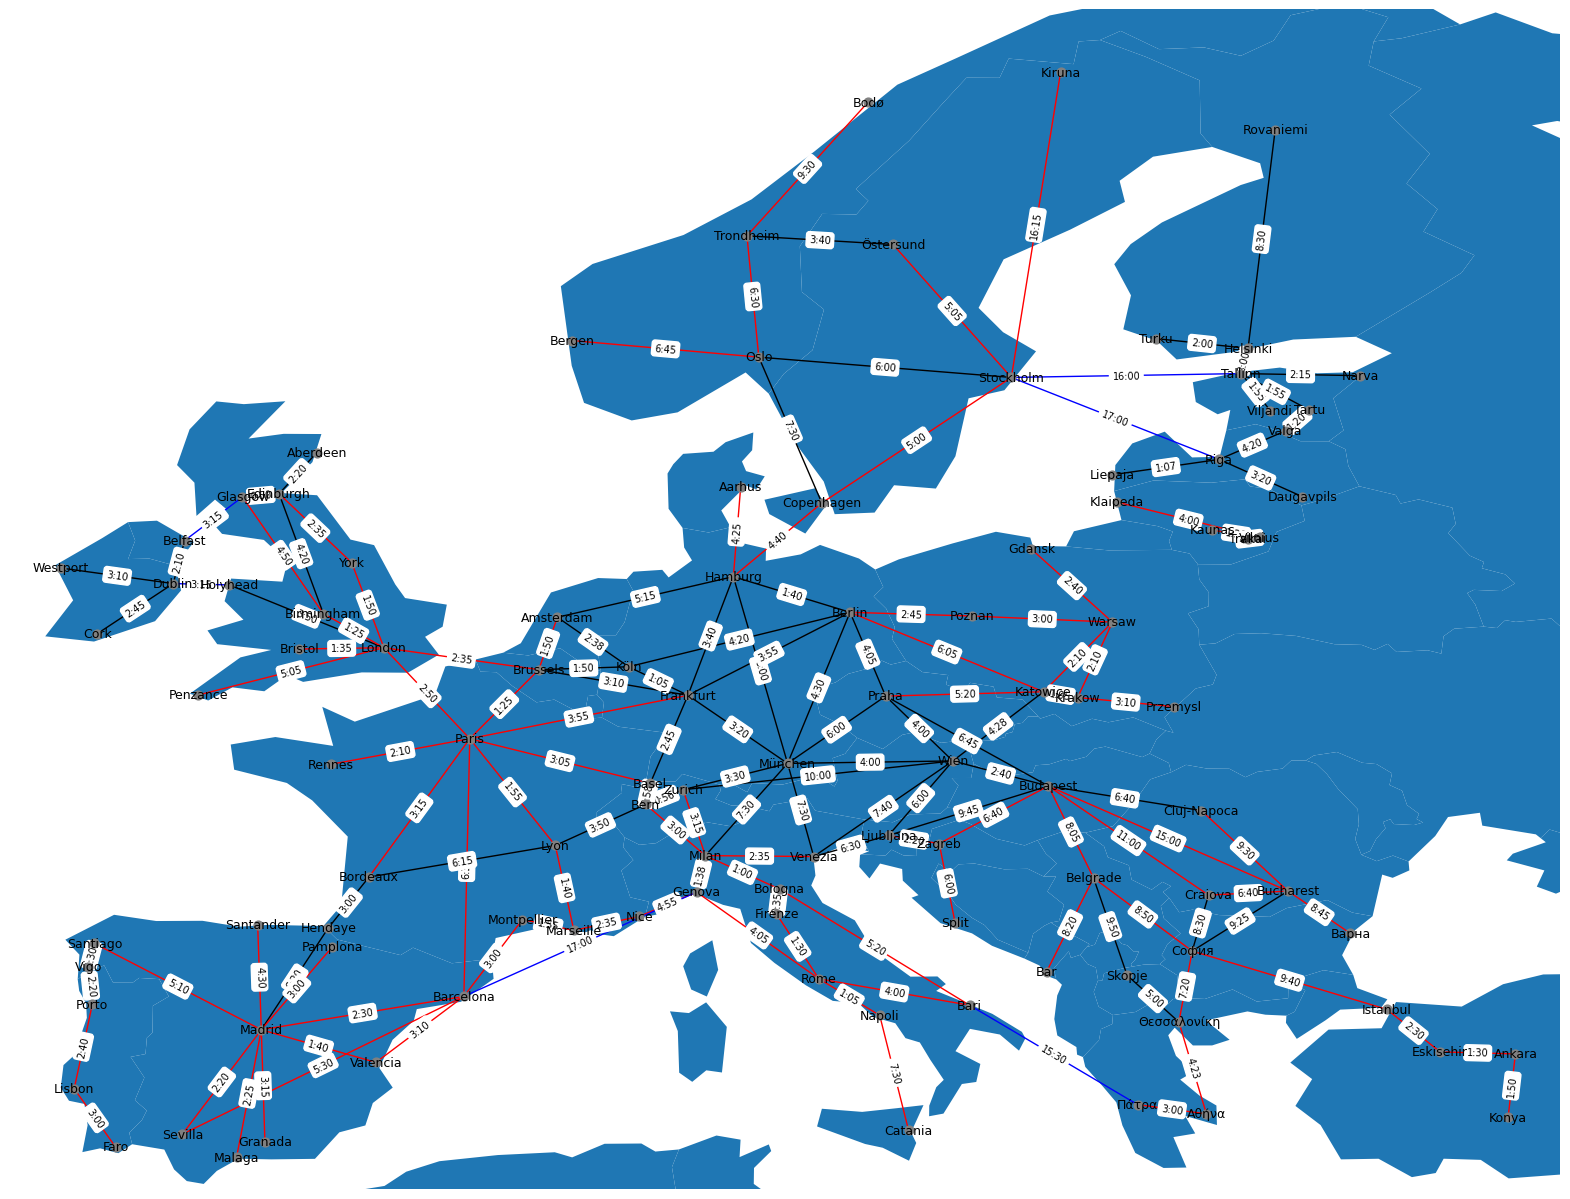

In [7]:
# plot graph using longitude and latitude features of nodes as x and y coordinates
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
import contextily as cx

def plot_graph(G, paths=None, weight="time", figsize=(20, 16)):
    pos = {city: (data["long"], data["lat"]) for city, data in G.nodes(data=True)}

    # add background map
    world = gpd.read_file("./data/map/ne_110m_admin_0_countries.shp")
    ax = world.plot(figsize=(20, 16))
    ax.set_xlim(-11, 34)
    ax.set_ylim(35.8, 70)

    # color edges blue if they are a ferry & red if they are a reservation
    edge_colors = [
        "blue" if data["type"] == "ferry" 
        else "red" if data["type"] == "reservation" 
        else "black" for u, v, data in G.edges(data=True)]

    # add edge feature "time" in format hh:mm to the plot
    edge_labels = {(u, v): f"{data['time']//60}:{data['time']%60:02d}" for u, v, data in G.edges(data=True)}

    nx.draw(G, pos, with_labels=True, node_size=40, font_size=9, node_color="grey", edge_color=edge_colors, ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, ax=ax)

    # add paths to the plot
    if paths:
        for path in paths:
            edges = list(zip(path, path[1:]))
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="pink", width=2, ax=ax)

    plt.show()

plot_graph(G)

# Getting from Brussels to Belgrade


### Naive approach: Shortest path

The naive approach is to find the shortest path from Brussels to Belgrade, without taking into account city preferences. This demonstates that the destination can be reached within the total travel time.

Total time from Brussels to Belgrade: 1260 minutes


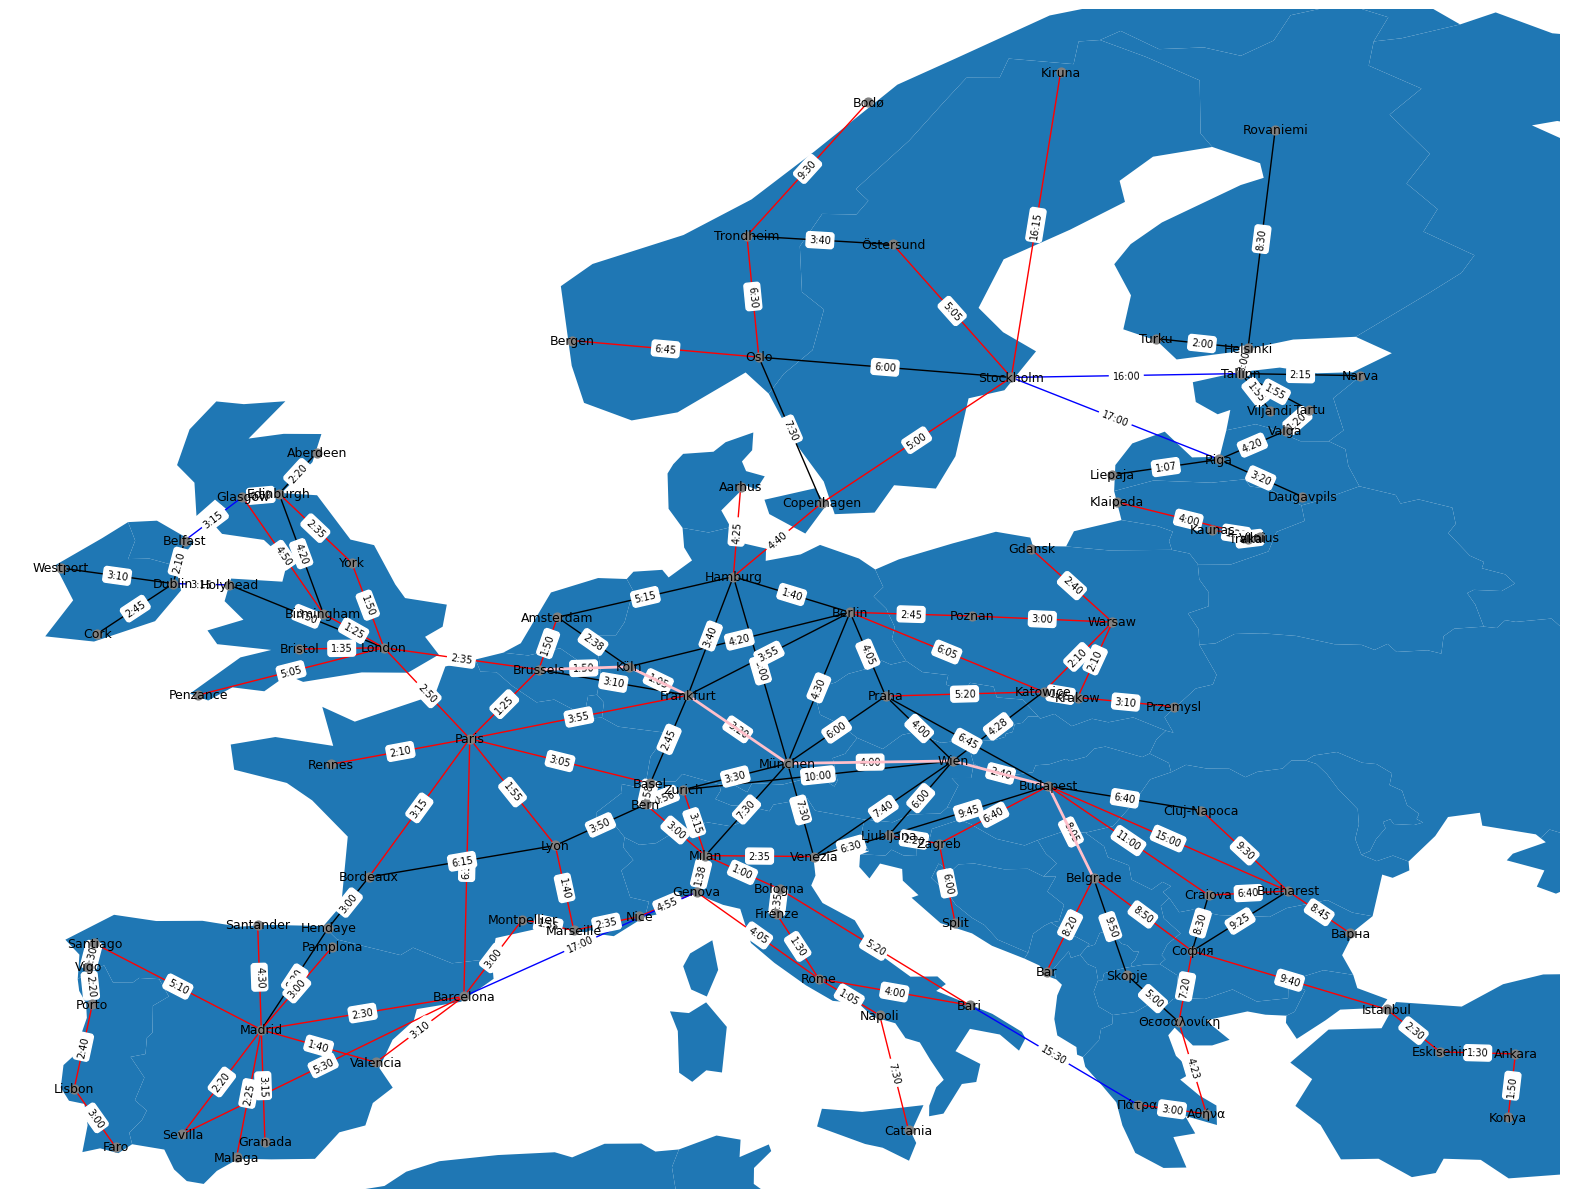

In [8]:
# shortest path from Brussels to Belgrade
def shortest_path(G, source, target, weight="time"):
    path = nx.shortest_path(G, source=source, target=target, weight=weight)
    time_sum = sum([G.edges[path[i], path[i+1]]["time"] for i in range(len(path)-1)])
    return path, time_sum

path, time_sum = shortest_path(G, "Brussels", "Belgrade")
print("Total time from Brussels to Belgrade:", time_sum, "minutes")
plot_graph(G, paths=[path])


### Formal problem definition

Given:

A graph of cities in Europe $G = (V,E)$ where:
- $V$ is the set of cities (nodes) with $\text{score}(v)$ for each city $v \in V$
- $E$ is the set of railway connections between cities (edges) with $\text{time}(e)$ for each connection $e \in E$

Objective:
- Time-restricted path from
  - Source city $S \in V$ (Brussels)
  - Destination city $D \in V$ (Belgrade)
- Obejctive function: maximize total city scores on path from $S$ to $D$.  $     \max \sum_{v \in V} \text{{score}}(v)  $

Constraints:
- Total travel time $T_{\text{total}}$ (17280 minutes or 12 days)
- Number of travel days $T_{\text{\#days}}$ (4, 5, 7)
- Travel time per day $T_{\text{day}}$ (540 minutes or 9 hours)

### Setting up hyperparameters

In [9]:
# Interrail travel days constraints
travel_days = 4
travel_day_max_time = 9 * 60

# Travel destination constraints
total_travel_days = 12
start = "Brussels"
end = "Belgrade"

# Travel constraints
# city_stop_time = 24 * 60
city_weights_user = {
    "Amsterdam": 2,
    "Berlin": 4,
    "Wien": 3,
    "Krakow": 3,
}
city_weights_base = 1

# add "score" feature to nodes
for city, data in G.nodes(data=True):
    if city in city_weights_user:
        G.nodes[city]["score"] = city_weights_user[city]
    elif city == start:
        G.nodes[city]["score"] = 0
    else:
        G.nodes[city]["score"] = city_weights_base

### The brute force approach

In [10]:
import random

def shuffle_path(path):
    temp = path.copy()
    random.shuffle(temp)
    return temp

def get_n_highest_scoring_cities(G, path, n):
    shuffled_path = shuffle_path(path[1:-1])
    city_scores = {city: G.nodes[city]["score"] for city in shuffled_path}
    max_scores = sorted(city_scores, key=city_scores.get, reverse=True)[:n]
    return max_scores

def check_proposed_path(G, proposed_path, travel_day_max_time, travel_days=4):
    path = proposed_path.copy()
    # print("before removal:", path)
    max_scores = get_n_highest_scoring_cities(G, path, n=travel_days-1)
    # propsed path, only including the highest scoring cities
    for city in proposed_path[1:-1]:
        if city not in max_scores:
            path.remove(city)

    # print("after removal:", path)

    # travel time between cities of proposed path
    for i, j in zip(path[:-1], path[1:]):
        _, time = shortest_path(G, i, j)
        # print(f"From {i} to {j}: {time} minutes")

        if time > travel_day_max_time:
            # print(f"Time between {i} and {j} is too long")
            return False
    return tuple(path)


def get_path_score(G, path):
    return sum([G.nodes[city]["score"] for city in path[1:-1]])


def get_first_n_simple_paths(G, source, target, travel_days=4, n_iter=100):
    simple_paths = nx.shortest_simple_paths(G, source, target, weight="time")
    possible_paths = set()
    i = 0
    for proposed_path in simple_paths:
        # print("checking path", i)
        i += 1
        path = check_proposed_path(G, proposed_path, travel_day_max_time, travel_days=travel_days)
        if path:
            score = get_path_score(G, path)
            # print(path, score)
            possible_paths.add((path, score))
        if i == n_iter:
            break
        # print("=================")
    return possible_paths


possible_paths = get_first_n_simple_paths(G, start, end, travel_days=travel_days, n_iter=2000)

In [11]:
len(possible_paths)
print(possible_paths)

{(('Brussels', 'Zurich', 'Wien', 'Budapest', 'Belgrade'), 5), (('Brussels', 'Frankfurt', 'München', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Berlin', 'Wien', 'Budapest', 'Belgrade'), 8), (('Brussels', 'Bern', 'Wien', 'Budapest', 'Belgrade'), 5), (('Brussels', 'Bern', 'München', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Berlin', 'München', 'Budapest', 'Belgrade'), 6), (('Brussels', 'Basel', 'München', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Berlin', 'Krakow', 'Budapest', 'Belgrade'), 8), (('Brussels', 'Frankfurt', 'Wien', 'Budapest', 'Belgrade'), 5), (('Brussels', 'Köln', 'Wien', 'Budapest', 'Belgrade'), 5), (('Brussels', 'Frankfurt', 'Praha', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Hamburg', 'München', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Berlin', 'Katowice', 'Budapest', 'Belgrade'), 6), (('Brussels', 'München', 'Wien', 'Budapest', 'Belgrade'), 5), (('Brussels', 'München', 'Praha', 'Budapest', 'Belgrade'), 3), (('Brussels', 'Milan', 'München', 'Budapest', 'Belgrade'

In [12]:
# sort possible paths by score
sorted_paths = sorted(possible_paths, key=lambda x: x[1], reverse=True)

def get_full_path(G, path):
    full_path = []
    for i, j in zip(path[:-1], path[1:]):
        path, time = shortest_path(G, i, j)
        full_path += path[:-1]
    full_path.append('Belgrade')
    return full_path

print("TOP 5 POSSIBLE PATHS ")

for i in range(5):
    path, tot_score = sorted_paths[i]
    score_list = [G.nodes[city]["score"] for city in path[1:-1]]
    stop_days = [round((item / tot_score) * total_travel_days) for item in score_list]

    if sum(stop_days) > total_travel_days:
        stop_days[-1] -= 1
    elif sum(stop_days) < total_travel_days:
        stop_days[-1] += 1

    full_path = get_full_path(G, path)    
    print("============================================================================================================================")
    print(f"Path {i+1}: {path}")
    print(f"Total score: {tot_score}")
    print(f"Stop days: {stop_days}")
    print(f"Full path: {full_path}")

print("============================================================================================================================")    

TOP 5 POSSIBLE PATHS 
Path 1: ('Brussels', 'Berlin', 'Wien', 'Budapest', 'Belgrade')
Total score: 8
Stop days: [6, 4, 2]
Full path: ['Brussels', 'Köln', 'Berlin', 'Praha', 'Wien', 'Budapest', 'Belgrade']
Path 2: ('Brussels', 'Berlin', 'Krakow', 'Budapest', 'Belgrade')
Total score: 8
Stop days: [6, 4, 2]
Full path: ['Brussels', 'Köln', 'Berlin', 'Katowice', 'Krakow', 'Katowice', 'Wien', 'Budapest', 'Belgrade']
Path 3: ('Brussels', 'Berlin', 'München', 'Budapest', 'Belgrade')
Total score: 6
Stop days: [8, 2, 2]
Full path: ['Brussels', 'Köln', 'Berlin', 'München', 'Wien', 'Budapest', 'Belgrade']
Path 4: ('Brussels', 'Berlin', 'Katowice', 'Budapest', 'Belgrade')
Total score: 6
Stop days: [8, 2, 2]
Full path: ['Brussels', 'Köln', 'Berlin', 'Katowice', 'Wien', 'Budapest', 'Belgrade']
Path 5: ('Brussels', 'Berlin', 'Praha', 'Budapest', 'Belgrade')
Total score: 6
Stop days: [8, 2, 2]
Full path: ['Brussels', 'Köln', 'Berlin', 'Praha', 'Wien', 'Budapest', 'Belgrade']


### Discussion

The brute force approach works very well in finding the most optimal path. However, it is not very efficient and can be very slow if you take up to 15 travel days. Therefore, we tried another way of approaching the problem, using a simmulated annealing algorithm. These results can be found in the "Simmulated_annealing" notebook.